In [42]:
import h5py
import numpy as np
import pandas as pd

with h5py.File('RespCoupling.Mat', 'r') as file:
    # Extract the data matrix
    data_matrix = np.array(file['fArray'])
    
    # Extract the feature names
    feature_names = []
    for ref in file['fNames']:
        # Dereference the object reference
        name_data = file[ref[0]]
        # Convert the uint16 array to a string
        name = ''.join(chr(i[0]) for i in name_data[:])
        feature_names.append(name)

# Create a DataFrame
resp_df = pd.DataFrame(data_matrix.T, columns=feature_names)

# Display the first few rows and info of the DataFrame
print(resp_df.head())
print("\
DataFrame Info:")
resp_df.info()

# Save the DataFrame to a CSV file
csv_filename = 'RespCoupling.csv'
resp_df.to_csv(csv_filename, index=False)
print(f"\
Data saved to {csv_filename}")

print("Done")



    SN  Label  breathNumber  taskOrder  loadOrderCT  timeOfBreath   Age  Sex  \
0  3.0    1.0           2.0        2.0          1.0      3.527500  27.0  0.0   
1  3.0    1.0           3.0        2.0          1.0      6.355000  27.0  0.0   
2  3.0    1.0           4.0        2.0          1.0      9.388333  27.0  0.0   
3  3.0    1.0           5.0        2.0          1.0     13.041667  27.0  0.0   
4  3.0    1.0           6.0        2.0          1.0     16.673333  27.0  0.0   

   Height  Weight  ...  lagCoef_{0.50}  lagCoef_{0.75}     % RCi  TP_{RC,0}  \
0   158.0    52.9  ...       -0.216789       -0.160364  0.668837   0.541774   
1   158.0    52.9  ...       -0.274332       -0.205534  0.724171   0.000000   
2   158.0    52.9  ...       -0.302754       -0.206114  0.753504   0.512530   
3   158.0    52.9  ...        0.086828        0.031575  0.438083   0.488389   
4   158.0    52.9  ...        0.102044        0.044175  0.465689   0.143559   

    TP_{AB,0}   TP_{RC,0.10}  TP_{AB,0.10}  

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data

df = pd.read_csv('RespCoupling.csv')

# 1. Basic information about the dataset
print("1. Basic Information about the Dataset:")
print(df.info())

# 2. Summary statistics
print("\n2. Summary Statistics:")
print(df.describe())

# 3. Check for missing values
print("\n3. Missing Values:")
print(df.isnull().sum())

#replace column names
df.columns = df.columns.str.replace('\
abla ', 'del_', regex=True)
df.columns = df.columns.str.replace('\t', '', regex=True)
df.columns = df.columns.str.replace("\\n", '')
df.columns = df.columns.str.strip()

print("Column names have been updated.")
print("\
Updated column names:")
print(df.columns.tolist())

print("Done")

df['Nicottine Use'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Define a function to remove outliers using the IQR method with adjustable factors
def remove_outliers_iqr(df, column, lower_factor=1.5, upper_factor=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - lower_factor * IQR
    upper_bound = Q3 + upper_factor * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply the IQR method to columns with extreme ranges
columns_to_clean = ['work', 'PTP', 'workPerLiter']

# Store the original shape
original_shape = df.shape[0]

# Remove outliers for each specified column
for column in columns_to_clean:
    df = remove_outliers_iqr(df, column)

# Display the new shape and percentage of data retained
print(f"Original dataset shape: {original_shape}")
print(f"Cleaned dataset shape: {df.shape[0]}")
print(f"Percentage of data retained: {df.shape[0] / original_shape * 100:.2f}%")

# Save the cleaned dataset to a new CSV file
cleaned_file_name = 'RespCoupling_cleaned_v2.csv'
df.to_csv(cleaned_file_name, index=False)
print(f"Cleaned dataset saved as '{cleaned_file_name}'")

# 4. Distribution of 'work' variable
plt.figure(figsize=(10, 6))
sns.histplot(df['work'], kde=True)
plt.title('Distribution of Work of Breathing')
plt.xlabel('Work')
plt.savefig('work_distribution.png')
plt.close()

# 5. Box plot of 'work' for each Label
plt.figure(figsize=(12, 6))
sns.boxplot(x='Label', y='work', data=df)
plt.title('Work of Breathing by Label')
plt.savefig('work_by_label_boxplot.png')
plt.close()

# 6. Correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.close()

# 7. Pairplot of key variables
key_vars = ['work', 'PTP', 'workPerLiter', 'Volume', 'T_i']
sns.pairplot(df[key_vars], diag_kind='kde')
plt.suptitle('Pairplot of Key Variables', y=1.02)
plt.savefig('key_variables_pairplot.png')
plt.close()

# 8. Time series plot of work for each label
plt.figure(figsize=(12, 6))
for label in df['Label'].unique():
    subset = df[df['Label'] == label]
    plt.plot(subset['timeOfBreath'], subset['work'], label=f'Label {label}')
plt.title('Work Over Time for Different Labels')
plt.xlabel('Time of Breath')
plt.ylabel('Work')
plt.legend()
plt.savefig('work_over_time.png')
plt.close()

# 9. Additional statistics
print("\n9. Unique values in 'Label' column:")
print(df['Label'].value_counts())

print("\n10. Correlation of 'work' with other variables:")
work_corr = df.corr()['work'].sort_values(ascending=False)
print(work_corr)

print("\nAll plots have been generated and saved.")

1. Basic Information about the Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9961 entries, 0 to 9960
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SN                       9961 non-null   float64
 1   Label                    9961 non-null   float64
 2   breathNumber             9961 non-null   float64
 3   taskOrder                9961 non-null   float64
 4   loadOrderCT              9961 non-null   float64
 5   timeOfBreath             9961 non-null   float64
 6   Age                      9961 non-null   float64
 7   Sex                      9961 non-null   float64
 8   Height                   9961 non-null   float64
 9   Weight                   9961 non-null   float64
 10  BMI                      9961 non-null   float64
 11  Body fat                 9961 non-null   float64
 12  Visceral fat             9961 non-null   float64
 13  Muscle                   9961 non-null

/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/var/folders/p1/vychbyg51cs0s16tvzh88pk00000gn/T/ipykernel_82414/1980402164.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Nicottine Use'].replace([np.i

Cleaned dataset saved as 'RespCoupling_cleaned_v2.csv'

9. Unique values in 'Label' column:
Label
2.0    2034
1.0    1982
4.0    1192
3.0    1180
5.0    1150
6.0    1130
Name: count, dtype: int64

10. Correlation of 'work' with other variables:
work                   1.000000
PTP                    0.879341
workPerLiter           0.859728
Volume                 0.382438
Label                  0.369402
C_{flow,RC}            0.349865
C_{flow,AB}            0.333556
T_i                    0.284254
MSSE_{flow}            0.209631
timeOfBreath           0.159046
breathNumber           0.142545
BMI                    0.098391
Visceral fat           0.098096
Body fat               0.092901
lagCoef_{0.25}         0.075643
% RCi                  0.073261
VR_{RC}                0.072690
loadOrderCT            0.063808
Waist Size             0.057996
Chest Circunference    0.057401
Age                    0.049693
lagCoef_{0.50}         0.049324
C_{del_RC,del_AB}      0.047335
Weight             

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import absolute
from numpy import sqrt

# Load the cleaned dataset
df = pd.read_csv('RespCoupling_cleaned_v2.csv')

# Separate features and target variables
X = df.drop(['work', 'PTP', 'workPerLiter','SN'], axis=1)
y_work = df['work']
y_ptp = df['PTP']
y_workPerLiter = df['workPerLiter']

# Handle non-numeric columns
X = pd.get_dummies(X, drop_first=True)

print("Data loaded and preprocessed.")
print(f"Shape of X: {X.shape}")
print(f"Shape of y_work: {y_work.shape}")

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split the data after imputation
X_train, X_test, y_work_train, y_work_test = train_test_split(X_imputed, y_work, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LASSO Feature Selection
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_work_train)
lasso_selector = SelectFromModel(lasso, prefit=True)
lasso_features = X.columns[lasso_selector.get_support()].tolist()

print("LASSO selected features:")
print(lasso_features)

# Random Forest Feature Selection
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_work_train)
rf_selector = SelectFromModel(rf, prefit=True)
rf_features = X.columns[rf_selector.get_support()].tolist()

# Feature importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\
Feature Importance:")
print(feature_importance)

print("\
Random Forest selected features:")
print(rf_features)

# Combine features from both methods
combined_features = list(set(lasso_features + rf_features))
print("\
Combined selected features:")
print(combined_features)

# Save the list of selected features
with open('selected_features.txt', 'w') as f:
    for feature in combined_features:
        f.write(f"{feature}\
")
cv = LeaveOneOut()

print("\
Selected features saved to 'selected_features.txt'")

Data loaded and preprocessed.
Shape of X: (8668, 39)
Shape of y_work: (8668,)
LASSO selected features:
['Label', 'loadOrderCT', 'timeOfBreath', 'Age', 'Height', 'Body fat', 'Visceral fat', 'Muscle', 'Chest Circunference', 'Waist Size', 'ActiveDays', 'C_{flow,AB}', 'C_{RC,AB}', 'C_{flow,del_RC}', 'C_{del_RC,del_AB}', 'MSSE_{flow}', 'MSSE_{RC}', 'MSSE_{AB}', 'VR_{AB}', 'T_i', 'Volume', 'lagCoef_{0.25}', '% RCi', 'TP_{RC,0}']
Feature Importance:
                feature  importance
30               Volume    0.385945
0                 Label    0.183981
4          timeOfBreath    0.174838
14  Chest Circunference    0.042447
29                  T_i    0.026952
12               Muscle    0.023799
26            MSSE_{AB}    0.022702
10             Body fat    0.015549
7                Height    0.013836
25            MSSE_{RC}    0.011891
18          C_{flow,RC}    0.009763
28              VR_{AB}    0.006823
34                % RCi    0.006275
1          breathNumber    0.005286
2            

LOOCV score 4.119581659820517
Linear Regression Model for WoB Prediction:
Mean Squared Error: 17.65
Root Mean Squared Error: 4.20
R-squared: 0.57


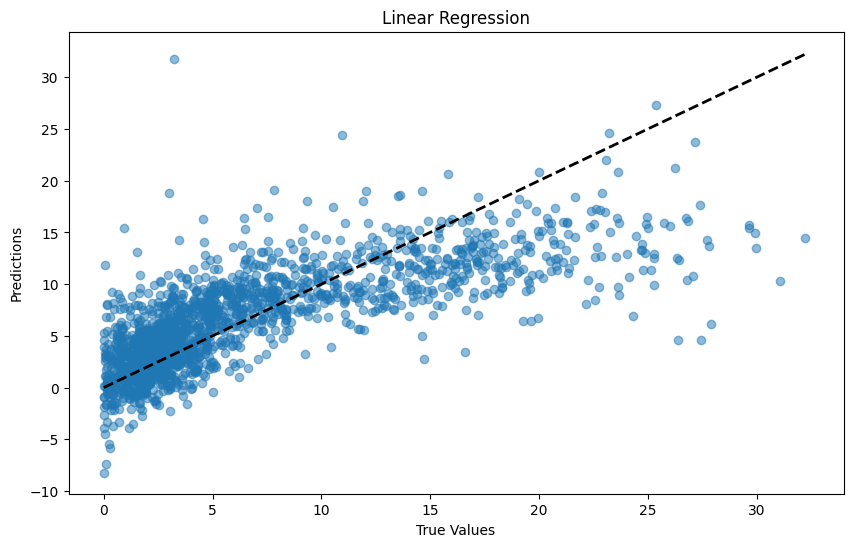

Regression model evaluation results saved to 'regression_model_evaluation.txt'


In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
y = pd.read_csv('target.csv')
# Use the combined selected features for regression
relevant_features = ['Volume', 'C_{flow,RC}', 'C_{flow,AB}', 'T_i', 'MSSE_{flow}']
X_selected = df[lasso_features]

# Impute missing values and scale the features
X_selected_imputed = imputer.fit_transform(X_selected)
X_train_sel, X_test_sel, y_work_train, y_work_test = train_test_split(X_selected_imputed, y_work, test_size=0.2, random_state=42)
X_train_sel_scaled = scaler.fit_transform(X_train_sel)
X_test_sel_scaled = scaler.transform(X_test_sel)

# Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(X_train_sel_scaled, y_work_train)

#use LOOCV to evaluate model
scores = cross_val_score(lin_reg, X_selected_imputed, y_work, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)

#view RMSE
L_rmse = sqrt(mean(absolute(scores)))
print(f"LOOCV score {L_rmse}")

# Predictions
y_work_pred = lin_reg.predict(X_test_sel_scaled)

# Evaluation
mse = mean_squared_error(y_work_test, y_work_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_work_test, y_work_pred)

print("Linear Regression Model for WoB Prediction:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")

# Plot the true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_work_test, y_work_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Linear Regression')
plt.savefig('linear_predvactual.jpg')
plt.show()

# Save the model evaluation results
with open('regression_model_evaluation.txt', 'w') as f:
    f.write(f"Mean Squared Error: {mse:.4f}\
")
    f.write(f"R-squared: {r2:.4f}\
")

print("\
Regression model evaluation results saved to 'regression_model_evaluation.txt'")

In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load the data
df = pd.read_csv('RespCoupling_cleaned_v2.csv')

# Select relevant features based on our previous analysis
relevant_features = ['Volume', 'C_{flow,RC}', 'C_{flow,AB}', 'T_i', 'MSSE_{flow}']
target = 'work'

# Create X (features) and y (target)
X = df[relevant_features]
y = df[target]

# Check for missing values
print("Missing values in features:")
print(X.isnull().sum())
print("\
Missing values in target:")
print(y.isnull().sum())

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Scale the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns)

print("\
Preprocessed data shape:")
print(X_scaled.shape)
print("\
First few rows of preprocessed data:")
print(X_scaled.head())

# Save preprocessed data for the next step
X_scaled.to_csv('preprocessed_features.csv', index=False)
y.to_csv('target.csv', index=False)

print("\
Preprocessed data saved to CSV files.")

# Load the preprocessed data
X = pd.read_csv('preprocessed_features.csv')
y = pd.read_csv('target.csv')

Missing values in features:
Volume         0
C_{flow,RC}    0
C_{flow,AB}    0
T_i            0
MSSE_{flow}    0
dtype: int64
Missing values in target:
0
Preprocessed data shape:
(8668, 5)
First few rows of preprocessed data:
     Volume  C_{flow,RC}  C_{flow,AB}       T_i  MSSE_{flow}
0  0.461714    -0.959183    -1.127045 -1.050843    -0.526167
1 -0.141695    -1.218966    -0.972418 -0.592097    -0.730342
2 -0.073162    -2.125094    -1.319957 -0.940161    -0.813281
3 -0.011014    -0.731342     0.019387 -0.734818    -0.274581
4 -0.387095     0.019335     0.989623 -0.073642     0.828747
Preprocessed data saved to CSV files.


Training set shape: (6934, 24)
Testing set shape: (1734, 24)
Model Performance:
Mean Squared Error: 2.8707
Root Mean Squared Error: 1.6943
R-squared: 0.9295
Feature Importance:
                feature  importance
11               Volume    0.391258
10                Label    0.189422
18         timeOfBreath    0.179765
1   Chest Circunference    0.046079
5                   T_i    0.028568
7                Muscle    0.025516
19            MSSE_{AB}    0.024698
16             Body fat    0.016449
22            MSSE_{RC}    0.013113
21               Height    0.011602
23              VR_{AB}    0.008652
6                 % RCi    0.007524
4          Visceral fat    0.006789
0            Waist Size    0.006432
3           C_{flow,AB}    0.005779
8             TP_{RC,0}    0.005293
14          MSSE_{flow}    0.005164
9        lagCoef_{0.25}    0.005162
20      C_{flow,del_RC}    0.005162
13            C_{RC,AB}    0.005032
12                  Age    0.004766
15    C_{del_RC,del_AB}    0.00

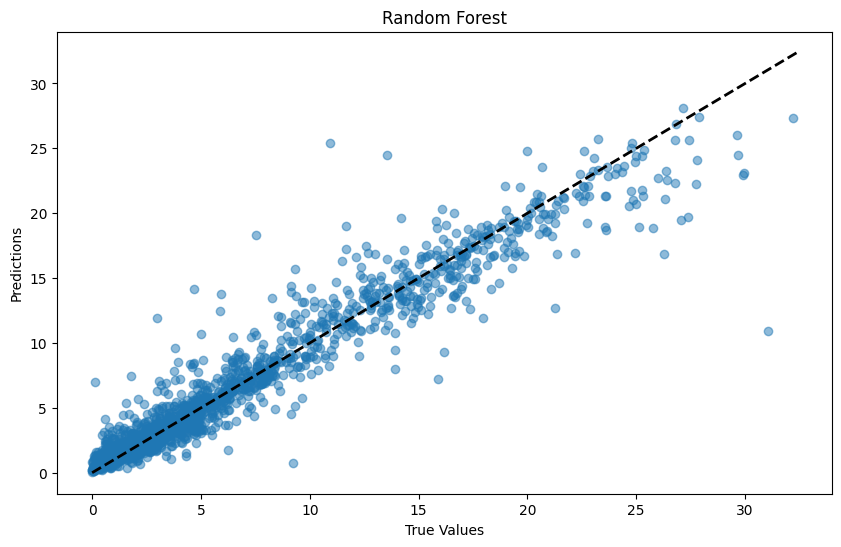

Model saved as 'random_forest_model.joblib'


In [47]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train.values.ravel())

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\
Model Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

# Feature importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\
Feature Importance:")
print(feature_importance)
#use LOOCV to evaluate model
scores = cross_val_score(rf_model, X, y_work, scoring='neg_mean_squared_error',cv=cv, n_jobs=-1)

#view RMSE
L_rmse = sqrt(mean(absolute(scores)))
print(f"LOOCV score {L_rmse}")

# Step 3: Visualize the model predictions
import matplotlib.pyplot as plt

# Plot the true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Random Forest')
plt.savefig('randomforest_predvactual')
plt.show()

# Save the model
import joblib
joblib.dump(rf_model, 'random_forest_model.joblib')
print("\
Model saved as 'random_forest_model.joblib'")

Training Gradient Boosting Regressor...
Gradient Boosting Model Performance:
Mean Squared Error: 4.6682
Root Mean Squared Error: 2.1606
R-squared: 0.8854
LOOCV score 2.1678714478714527
Gradient Boosting model saved as 'gradient_boosting_model.joblib'


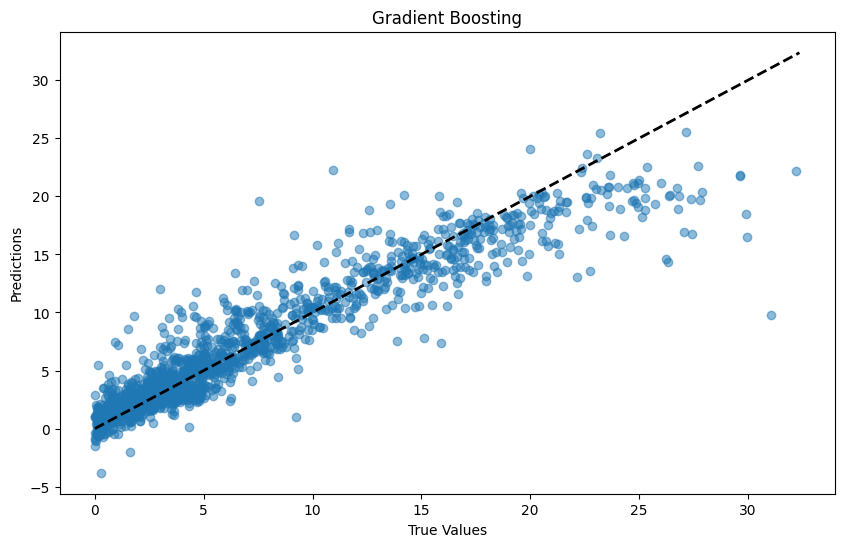

In [48]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# Train a Gradient Boosting Regressor
print("Training Gradient Boosting Regressor...")
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train.values.ravel())

# Make predictions on the test set
y_pred_gb = gb_model.predict(X_test)

# Calculate performance metrics for Gradient Boosting
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print("\
Gradient Boosting Model Performance:")
print(f"Mean Squared Error: {mse_gb:.4f}")
print(f"Root Mean Squared Error: {rmse_gb:.4f}")
print(f"R-squared: {r2_gb:.4f}")
#use LOOCV to evaluate model
scores = cross_val_score(gb_model, X, y_work, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)

#view RMSE
L_rmse = sqrt(mean(absolute(scores)))
print(f"LOOCV score {L_rmse}")

# Save the Gradient Boosting model
joblib.dump(gb_model, 'gradient_boosting_model.joblib')
print("\
Gradient Boosting model saved as 'gradient_boosting_model.joblib'")

# Plot the true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gb, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Gradient Boosting')
plt.savefig('gradientboosting_predvactual')
plt.show()



Training Neural Network Regressor...
Neural Network Model Performance:
Mean Squared Error: 13.6917
Root Mean Squared Error: 3.7002
R-squared: 0.6638


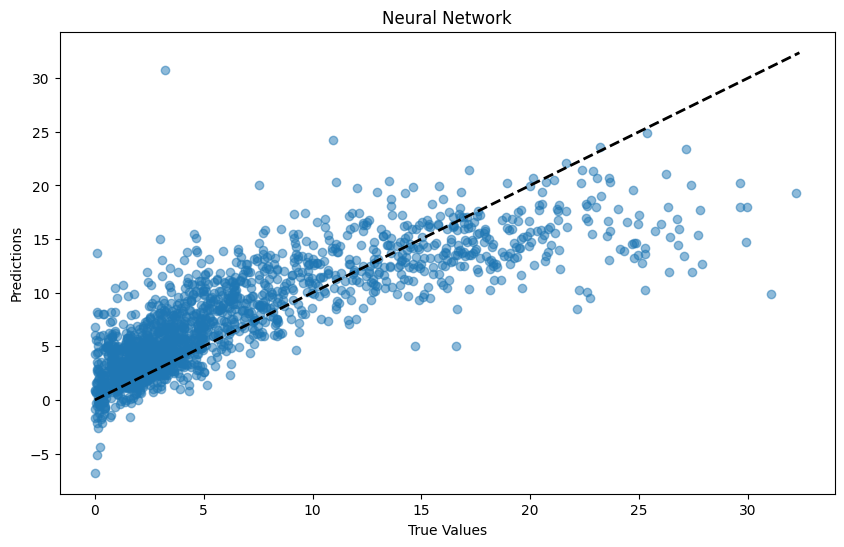

Neural Network model saved as 'neural_network_model.joblib'


In [65]:
from sklearn.neural_network import MLPRegressor

# Train a Neural Network Regressor
print("Training Neural Network Regressor...")
mlp_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train.values.ravel())

# Make predictions on the test set
y_pred_mlp = mlp_model.predict(X_test)

# Calculate performance metrics for Neural Network
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
rmse_mlp = np.sqrt(mse_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)
#use LOOCV to evaluate model
#scores = cross_val_score(mlp_model, X, y_work, scoring='neg_mean_squared_error',cv=cv, n_jobs=-1)

#view RMSE
#L_rmse = sqrt(mean(absolute(scores)))
#print(f"LOOCV score {L_rmse}")

print("\
Neural Network Model Performance:")
print(f"Mean Squared Error: {mse_mlp:.4f}")
print(f"Root Mean Squared Error: {rmse_mlp:.4f}")
print(f"R-squared: {r2_mlp:.4f}")

# Plot the true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_mlp, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Neural Network')
plt.savefig('neuralnetwork_predvactual')
plt.show()

# Save the Neural Network model
joblib.dump(mlp_model, 'neural_network_model.joblib')
print("\
Neural Network model saved as 'neural_network_model.joblib'")

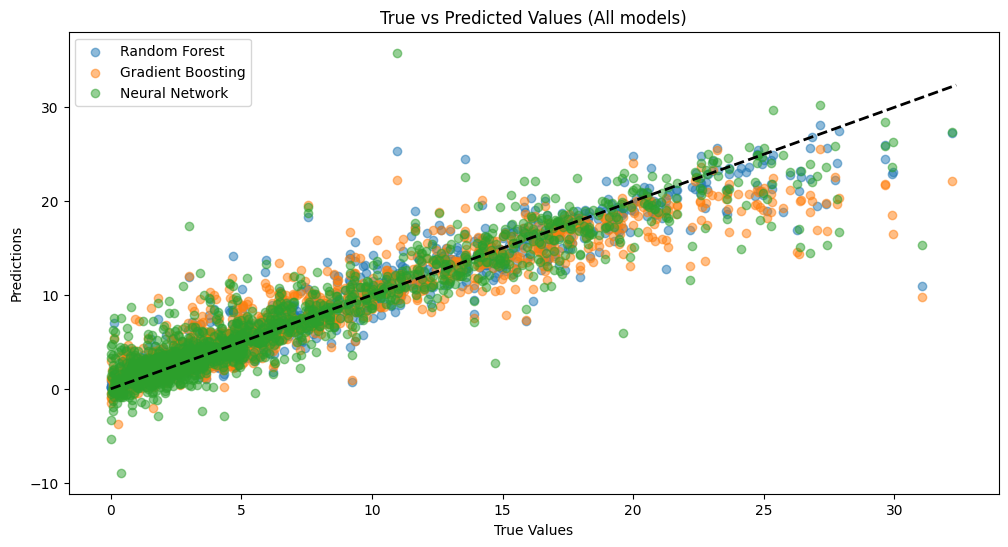

In [50]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Random Forest')
plt.scatter(y_test, y_pred_gb, alpha=0.5, label='Gradient Boosting')
plt.scatter(y_test, y_pred_mlp, alpha=0.5, label='Neural Network')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values (All models)')
plt.savefig('combined_predvactual', bbox_inches='tight')
plt.legend()
plt.show()

In [51]:
import matplotlib.pyplot as plt

# Plot breath-by-breath changes in Work of Breathing
plt.figure(figsize=(14, 6))
plt.plot(df['timeOfBreath'], df['work'], marker='o', linestyle='-', markersize=3)
plt.title('Breath-by-Breath Changes in Work of Breathing')
plt.xlabel('Time of Breath')
plt.ylabel('Work of Breathing')
plt.grid(True)
plt.tight_layout()
plt.savefig('breath_by_breath_wob.png')
plt.close()

print("Breath-by-breath changes in Work of Breathing plotted and saved as 'breath_by_breath_wob.png'.")

# Calculate rolling mean to smooth the data and observe trends
rolling_window = 50  # Adjust the window size as needed

df['rolling_work'] = df['work'].rolling(window=rolling_window, min_periods=1).mean()

# Plot the rolling mean of Work of Breathing over time
plt.figure(figsize=(14, 6))
plt.plot(df['timeOfBreath'], df['rolling_work'], color='orange', label='Rolling Mean of WoB')
plt.title('Adaptation Patterns in Work of Breathing Over Time')
plt.xlabel('Time of Breath')
plt.ylabel('Rolling Mean of Work of Breathing')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('adaptation_patterns_wob.png')
plt.close()

print("Adaptation patterns in Work of Breathing over time plotted and saved as 'adaptation_patterns_wob.png'.")

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# Prepare the data for time series modeling
# We'll use the rolling mean of WoB as the target variable for predicting fatigue onset
# Assume fatigue onset is indicated by a significant increase in WoB

# Define a threshold for fatigue onset (e.g., 1.5 times the rolling mean)


# Initialize a dictionary to store models and forecasts
arima_models = {}
forecasts = {}


grouped = df.groupby('Label')

# Iterate over each group
for label, group in grouped:
    try:
                # Plot the rolling mean of Work of Breathing over time
        plt.figure(figsize=(14, 6))
        plt.plot(group['timeOfBreath'], group['rolling_work'], color='orange', label='Rolling Mean of WoB')
        plt.title(f'Adaptation Patterns in Work of Breathing Over Time {label}')
        plt.xlabel('Time of Breath')
        plt.ylabel('Rolling Mean of Work of Breathing')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'adaptation_patterns_wob_{label}.png')
        plt.close()

        print("Adaptation patterns in Work of Breathing over time plotted and saved as 'adaptation_patterns_wob.png'.")

        fatigue_threshold = 1.5 * group['rolling_work'].mean()

        group['fatigue_onset'] = (group['rolling_work'] > fatigue_threshold).astype(int)

        # Split the data into training and testing sets
        train_size = int(len(group) * 0.8)
        train, test = group[:train_size], group[train_size:]
        # Set 'timeOfBreath' as the index
        group.set_index('timeOfBreath', inplace=True)
        
        # Fit ARIMA model for 'work'
        model = ARIMA(group['rolling_work'], order=(1, 1, 1))
        model_fit = model.fit()
        
        # Store the model
        arima_models[label] = model_fit
        
        # Forecast future values
        forecast = model_fit.forecast(steps=len(test))
        forecasts[label] = forecast

        # Evaluate the model's performance
        mse_arima = mean_squared_error(test['rolling_work'], forecast)
        rmse_arima = np.sqrt(mse_arima)

        print("ARIMA Model Performance:")
        print(f"Mean Squared Error: {mse_arima:.4f}")
        print(f"Root Mean Squared Error: {rmse_arima:.4f}")
        
        print('ARIMA model fitted and forecasted for Label:', label)

        # Plot the actual vs. predicted values
        plt.figure(figsize=(14, 6))
        plt.plot(test['timeOfBreath'], test['rolling_work'], label='Actual WoB', color='blue')
        plt.plot(test['timeOfBreath'], forecast, label='Predicted WoB', color='red')
        plt.axhline(y=fatigue_threshold, color='green', linestyle='--', label='Fatigue Threshold')
        plt.title(f'Actual vs. Predicted Work of Breathing with Fatigue Threshold {label}')
        plt.xlabel('Time of Breath')
        plt.ylabel('Work of Breathing')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'arima_wob_predictions_{label}.png')
        plt.close()
    except Exception as e:
        print('Error for Label', label, ':', e)


print("ARIMA model predictions plotted and saved as 'arima_wob_predictions.png'.")


Breath-by-breath changes in Work of Breathing plotted and saved as 'breath_by_breath_wob.png'.
Adaptation patterns in Work of Breathing over time plotted and saved as 'adaptation_patterns_wob.png'.
Adaptation patterns in Work of Breathing over time plotted and saved as 'adaptation_patterns_wob.png'.
ARIMA Model Performance:
Mean Squared Error: 5.6544
Root Mean Squared Error: 2.3779
ARIMA model fitted and forecasted for Label: 1.0


/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/

Adaptation patterns in Work of Breathing over time plotted and saved as 'adaptation_patterns_wob.png'.
ARIMA Model Performance:
Mean Squared Error: 6.8316
Root Mean Squared Error: 2.6137
ARIMA model fitted and forecasted for Label: 2.0


/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/

Adaptation patterns in Work of Breathing over time plotted and saved as 'adaptation_patterns_wob.png'.
ARIMA Model Performance:
Mean Squared Error: 10.0137
Root Mean Squared Error: 3.1644
ARIMA model fitted and forecasted for Label: 3.0


/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/

Adaptation patterns in Work of Breathing over time plotted and saved as 'adaptation_patterns_wob.png'.
ARIMA Model Performance:
Mean Squared Error: 5.0999
Root Mean Squared Error: 2.2583
ARIMA model fitted and forecasted for Label: 4.0


/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/

Adaptation patterns in Work of Breathing over time plotted and saved as 'adaptation_patterns_wob.png'.
ARIMA Model Performance:
Mean Squared Error: 7.4890
Root Mean Squared Error: 2.7366
ARIMA model fitted and forecasted for Label: 5.0


/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/

Adaptation patterns in Work of Breathing over time plotted and saved as 'adaptation_patterns_wob.png'.
ARIMA Model Performance:
Mean Squared Error: 12.2322
Root Mean Squared Error: 3.4975
ARIMA model fitted and forecasted for Label: 6.0
ARIMA model predictions plotted and saved as 'arima_wob_predictions.png'.


/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/

In [52]:
# Import necessary libraries
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'data' is our time series
# If 'data' is not defined, uncomment and run the following lines:
df = pd.read_csv('RespCoupling_cleaned_v2.csv')
df['timeOfBreath'] = pd.to_datetime(df['timeOfBreath'])
df = df.sort_values('timeOfBreath')
data = df['work']
rolling_window = 50  # Adjust the window size as needed
df['rolling_work'] = df['work'].rolling(window=rolling_window, min_periods=1).mean()
# Define a range of p, d, q values to test
p_values = range(0, 3)  # 0 to 5
d_values = range(0, 2)  # 0 to 2
q_values = range(0, 3)  # 0 to 5

# Store AIC values for each combination
aic_values = []
orders = []
grouped = df.groupby('Label')
for label, group in grouped:
    # Iterate over all combinations of p, d, q
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    # Fit the ARIMA model
                    model = ARIMA(group['rolling_work'], order=(p, d, q))
                    model_fit = model.fit()
                    # Store the AIC value
                    aic_values.append(model_fit.aic)
                    orders.append((p, d, q))
                except:
                    continue

    # Convert results to a DataFrame
    aic_df = pd.DataFrame({'Order': orders, 'AIC': aic_values})
    best_models = aic_df.sort_values('AIC').head(5)
    print("Top 5 models with the lowest AIC values:")
    print(best_models)


# Display the top 5 models with the lowest AIC values
best_models = aic_df.sort_values('AIC').head(5)
print("Top 5 models with the lowest AIC values:")
print(best_models)

# Generate ACF plot
plt.figure(figsize=(12, 6))
plot_acf(data, lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.tight_layout()
plt.savefig('acf_plot.png')
plt.close()

# Generate PACF plot
plt.figure(figsize=(12, 6))
plot_pacf(data, lags=40)
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.savefig('pacf_plot.png')
plt.close()

print("ACF and PACF plots have been generated and saved as 'acf_plot.png' and 'pacf_plot.png'.")

# Let's compare the AIC value of the ARIMA(1, 1, 1) model with other models
# We have already calculated AIC values for a range of models in the previous steps

# Display the top 5 models with the lowest AIC values


/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.p

Top 5 models with the lowest AIC values:
        Order          AIC
16  (2, 1, 1)  1495.903623
11  (1, 1, 2)  1495.923888
10  (1, 1, 1)  1497.885769
17  (2, 1, 2)  1497.906900
14  (2, 0, 2)  1499.773274


/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.p

Top 5 models with the lowest AIC values:
        Order          AIC
28  (1, 1, 1)  1391.795054
34  (2, 1, 1)  1393.732732
29  (1, 1, 2)  1393.733855
35  (2, 1, 2)  1395.550508
31  (2, 0, 1)  1395.567286


/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.p

Top 5 models with the lowest AIC values:
        Order          AIC
28  (1, 1, 1)  1391.795054
34  (2, 1, 1)  1393.732732
29  (1, 1, 2)  1393.733855
35  (2, 1, 2)  1395.550508
31  (2, 0, 1)  1395.567286


/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.p

Top 5 models with the lowest AIC values:
        Order          AIC
28  (1, 1, 1)  1391.795054
34  (2, 1, 1)  1393.732732
29  (1, 1, 2)  1393.733855
35  (2, 1, 2)  1395.550508
31  (2, 0, 1)  1395.567286


/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.p

Top 5 models with the lowest AIC values:
        Order          AIC
28  (1, 1, 1)  1391.795054
34  (2, 1, 1)  1393.732732
29  (1, 1, 2)  1393.733855
35  (2, 1, 2)  1395.550508
31  (2, 0, 1)  1395.567286


/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shreyas/UF/Fall24/FML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.p

Top 5 models with the lowest AIC values:
         Order          AIC
100  (1, 1, 1)  1378.554066
101  (1, 1, 2)  1380.485942
106  (2, 1, 1)  1380.486963
107  (2, 1, 2)  1382.401230
103  (2, 0, 1)  1386.111849
Top 5 models with the lowest AIC values:
         Order          AIC
100  (1, 1, 1)  1378.554066
101  (1, 1, 2)  1380.485942
106  (2, 1, 1)  1380.486963
107  (2, 1, 2)  1382.401230
103  (2, 0, 1)  1386.111849
ACF and PACF plots have been generated and saved as 'acf_plot.png' and 'pacf_plot.png'.


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

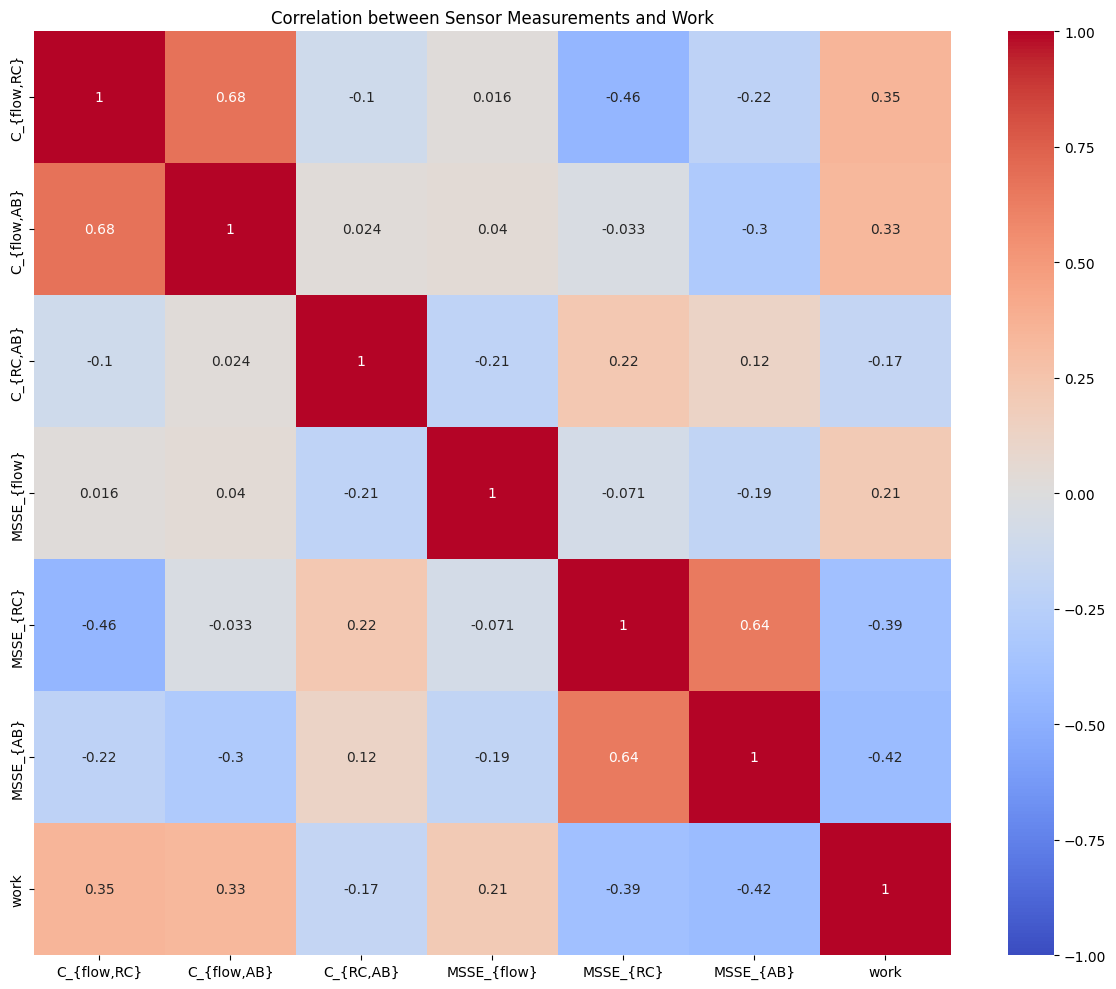

Mean values for sensor measurements and work across load conditions:
                   C_{flow,RC}  C_{flow,AB}  C_{RC,AB}  MSSE_{flow}  \
Load_Condition                                                        
High load (CST)       0.437748     0.172739   0.841476     0.459689   
High load (PVT)       0.511067     0.227049   0.837061     0.470281   
Medium Load (CST)     0.505160     0.313035   0.820972     0.418561   
Medium Load (PVT)     0.469125     0.286971   0.849986     0.507622   
No load (CST)         0.258565     0.131491   0.940820     0.311925   
No load (PVT)         0.277016     0.162234   0.936647     0.302954   

                   MSSE_{RC}  MSSE_{AB}      work  
Load_Condition                                     
High load (CST)     0.894457   1.361804  7.908818  
High load (PVT)     0.828654   1.333039  9.369881  
Medium Load (CST)   0.859693   1.247913  9.368621  
Medium Load (PVT)   0.935314   1.236023  9.626537  
No load (CST)       1.420440   1.690101  3.420604 

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Create a mapping for load conditions
load_mapping = {
    1: 'No load (CST)',
    2: 'No load (PVT)',
    3: 'Medium Load (CST)',
    4: 'Medium Load (PVT)',
    5: 'High load (CST)',
    6: 'High load (PVT)'
}

df['Load_Condition'] = df['Label'].map(load_mapping)

# Select relevant features for sensor measurements and performance
sensor_features = ['C_{flow,RC}', 'C_{flow,AB}', 'C_{RC,AB}', 'MSSE_{flow}', 'MSSE_{RC}', 'MSSE_{AB}']
performance_feature = 'work'  # We'll use 'work' as a proxy for performance

# Create a correlation matrix
correlation_matrix = df[sensor_features + [performance_feature]].corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation between Sensor Measurements and Work')
plt.tight_layout()
plt.show()

# Calculate mean values for sensor measurements across load conditions
mean_values = df.groupby('Load_Condition')[sensor_features + [performance_feature]].mean()
print("Mean values for sensor measurements and work across load conditions:")
print(mean_values)

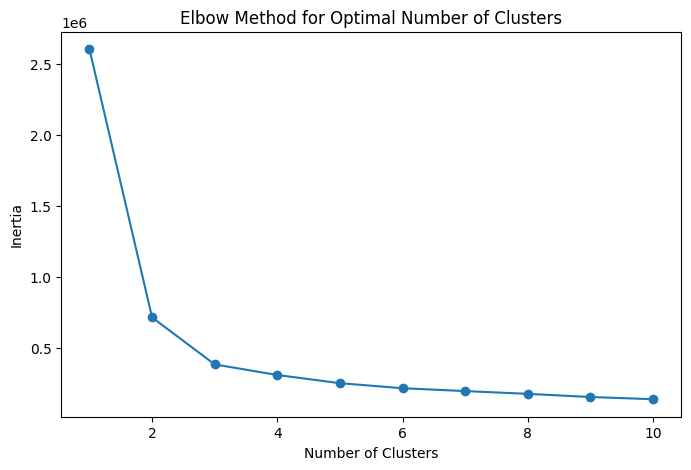

In [54]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Perform cluster analysis on the dataset to identify different compensation strategies
# We'll use the features related to compensation strategies for clustering
compensation_features = ['Volume', 'T_i', '% RCi', 'work', 'PTP', 'workPerLiter']
X_compensation = df[compensation_features].values

# Determine the optimal number of clusters using the elbow method
inertia = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_compensation)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.savefig('elbow_method_clusters.png')
plt.show()

Cluster Means:
           Volume       T_i     % RCi       work        PTP  workPerLiter
Cluster                                                                  
0        0.750719  1.855700  0.319544  15.966991  34.564040     23.278983
1        0.835124  1.599847  0.509688   4.385050   7.258312      5.002600
2        0.551710  1.435802  0.253254   3.168059   7.895152      6.113560


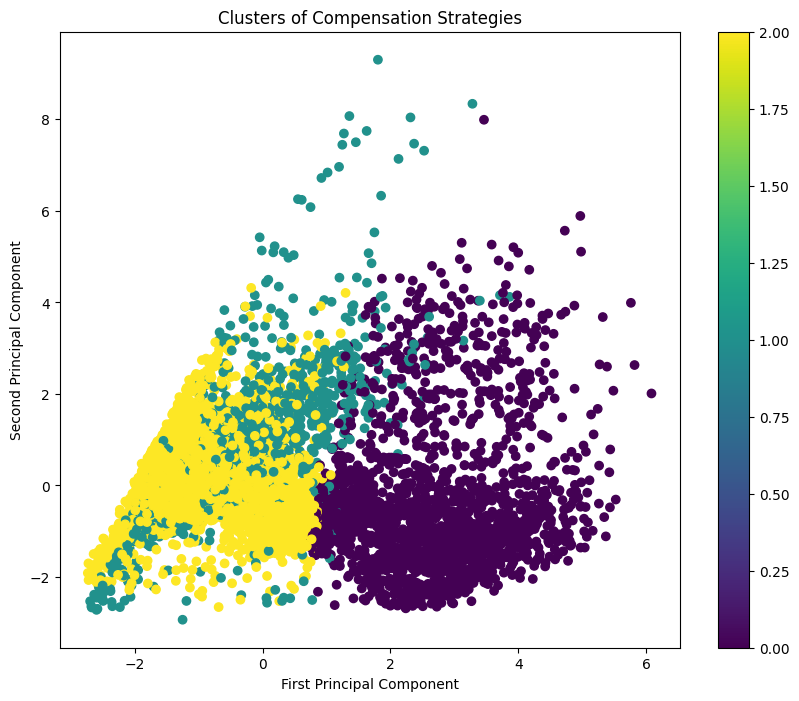

Number of samples in each cluster:
Cluster
2    4894
0    2058
1    1716
Name: count, dtype: int64


In [55]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Standardize the features
scaler = StandardScaler()
X_compensation_scaled = scaler.fit_transform(X_compensation)

# Perform K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_compensation_scaled)

# Add cluster labels to the dataframe
df['Cluster'] = cluster_labels

# Analyze cluster characteristics
cluster_means = df.groupby('Cluster')[compensation_features].mean()
print("Cluster Means:")
print(cluster_means)

# Visualize clusters using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_compensation_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('Clusters of Compensation Strategies')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.savefig('pca_clusters.png')
plt.colorbar(scatter)
plt.show()

# Print the number of samples in each cluster
print("\
Number of samples in each cluster:")
print(df['Cluster'].value_counts())

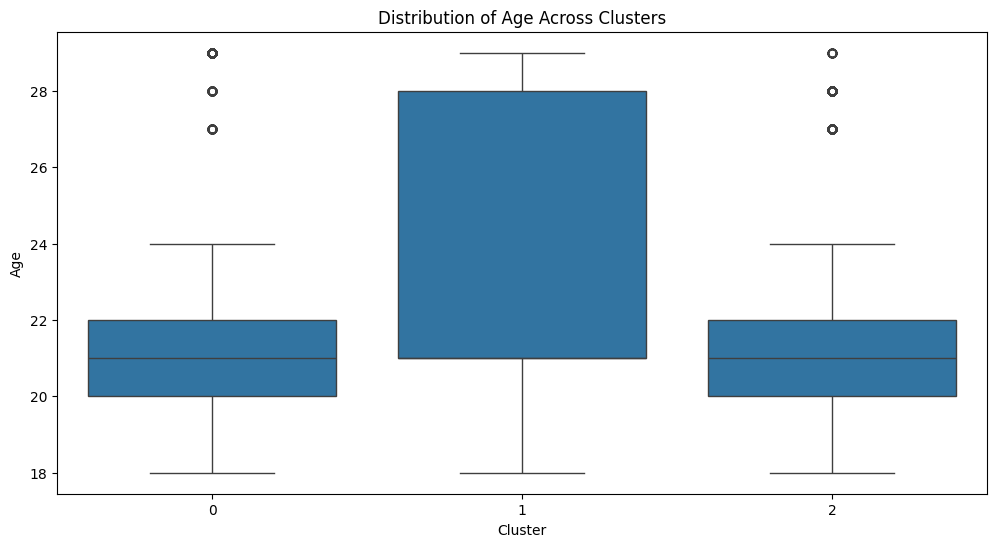

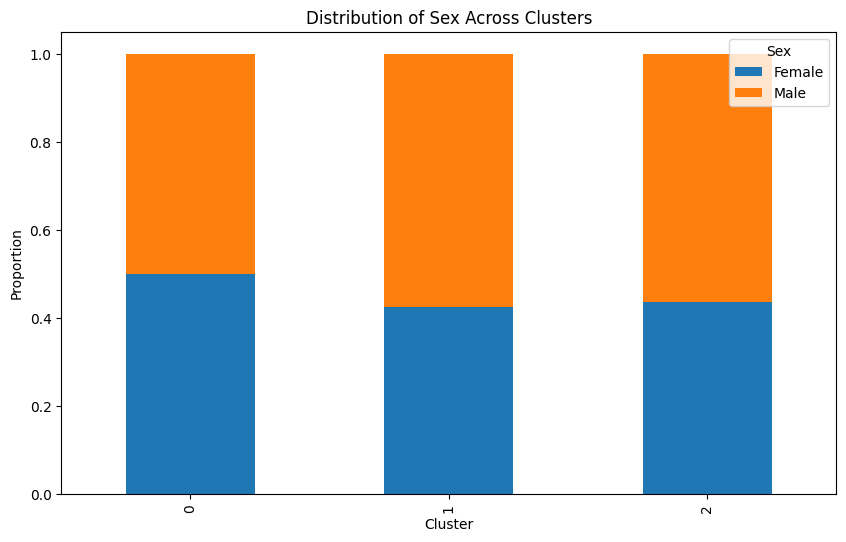

ANOVA test for age differences between clusters:
F-statistic: 319.7446970989344, p-value: 1.0516342519978767e-134
Chi-square test for sex distribution across clusters:
Chi-square statistic: 27.38380603847942, p-value: 1.1315716857750804e-06
Cluster Summary:
               Age  Proportion_Male
Cluster                            
0        21.914480         0.501458
1        23.063520         0.575175
2        21.129751         0.563139


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Analyze the impact of age on compensation
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Age', data=df)
plt.title('Distribution of Age Across Clusters')
plt.savefig('distribution_age.png')
plt.show()

# Analyze the impact of sex on compensation
sex_cluster_crosstab = pd.crosstab(df['Cluster'], df['Sex'])
sex_cluster_crosstab_norm = sex_cluster_crosstab.div(sex_cluster_crosstab.sum(axis=1), axis=0)
sex_cluster_crosstab_norm.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribution of Sex Across Clusters')
plt.ylabel('Proportion')
plt.legend(title='Sex', labels=['Female', 'Male'])
plt.savefig('distributions_gender.png')
plt.show()

# Perform statistical tests
print("ANOVA test for age differences between clusters:")
f_statistic, p_value = stats.f_oneway(df[df['Cluster'] == 0]['Age'],
                                      df[df['Cluster'] == 1]['Age'],
                                      df[df['Cluster'] == 2]['Age'])
print(f"F-statistic: {f_statistic}, p-value: {p_value}")

print("\
Chi-square test for sex distribution across clusters:")
chi2, p_value, dof, expected = stats.chi2_contingency(sex_cluster_crosstab)
print(f"Chi-square statistic: {chi2}, p-value: {p_value}")

# Calculate mean age and sex distribution for each cluster
cluster_summary = df.groupby('Cluster').agg({
    'Age': 'mean',
    'Sex': lambda x: (x == 1).mean()  # Assuming 1 represents male
}).rename(columns={'Sex': 'Proportion_Male'})

print("\
Cluster Summary:")
print(cluster_summary)

In [57]:
import pandas as pd

# Define personalized training programs based on cluster characteristics
training_programs = {
    0: {
        "name": "Balanced Endurance Program",
        "focus": "Improve overall respiratory endurance",
        "exercises": [
            "Diaphragmatic breathing exercises",
            "Moderate-intensity aerobic training",
            "Inspiratory muscle training at 50% of maximal inspiratory pressure"
        ],
        "frequency": "3-4 times per week",
        "duration": "30-45 minutes per session"
    },
    1: {
        "name": "High-Volume Respiratory Program",
        "focus": "Enhance respiratory muscle strength and endurance",
        "exercises": [
            "High-volume breathing exercises",
            "Interval training with respiratory challenges",
            "Inspiratory muscle training at 60-70% of maximal inspiratory pressure"
        ],
        "frequency": "4-5 times per week",
        "duration": "45-60 minutes per session"
    },
    2: {
        "name": "Power Breathing Program",
        "focus": "Develop respiratory power and efficiency",
        "exercises": [
            "Power breathing techniques",
            "High-intensity interval training",
            "Inspiratory muscle training at 70-80% of maximal inspiratory pressure"
        ],
        "frequency": "3-4 times per week",
        "duration": "30-45 minutes per session"
    }
}

# Create a DataFrame from the training programs
training_df = pd.DataFrame.from_dict(training_programs, orient='index')

# Add cluster characteristics to the DataFrame
training_df['Mean Age'] = cluster_summary['Age']
training_df['Proportion Male'] = cluster_summary['Proportion_Male']

# Display the personalized training programs
print("Personalized Respiratory Training Programs:")
print(training_df)

# Calculate and display the distribution of participants across clusters
cluster_distribution = df['Cluster'].value_counts(normalize=True) * 100
print("\
Distribution of Participants Across Clusters:")
print(cluster_distribution)

Personalized Respiratory Training Programs:
                              name  \
0       Balanced Endurance Program   
1  High-Volume Respiratory Program   
2          Power Breathing Program   

                                               focus  \
0              Improve overall respiratory endurance   
1  Enhance respiratory muscle strength and endurance   
2           Develop respiratory power and efficiency   

                                           exercises           frequency  \
0  [Diaphragmatic breathing exercises, Moderate-i...  3-4 times per week   
1  [High-volume breathing exercises, Interval tra...  4-5 times per week   
2  [Power breathing techniques, High-intensity in...  3-4 times per week   

                    duration   Mean Age  Proportion Male  
0  30-45 minutes per session  21.914480         0.501458  
1  45-60 minutes per session  23.063520         0.575175  
2  30-45 minutes per session  21.129751         0.563139  
Distribution of Participants Across C

In [58]:
# Step 1: Analyze changes in breathing patterns across different loads using statistical methods
import scipy.stats as stats

# Create a mapping for the Label column
label_mapping = {
    1: 'No load - CST',
    2: 'No load - PVT',
    3: 'Medium Load - CST',
    4: 'Medium Load - PVT',
    5: 'High load - CST',
    6: 'High load - PVT'
}

# Apply the mapping to create a new column
df['Task_Load'] = df['Label'].map(label_mapping)

# Group data by Task_Load and calculate descriptive statistics
breathing_stats = df.groupby('Task_Load')[['Volume', 'T_i', 'work', 'PTP', 'workPerLiter']].describe()

# Perform ANOVA to test for differences in breathing patterns across different loads
anova_results = {}
for metric in ['Volume', 'T_i', 'work', 'PTP', 'workPerLiter']:
    groups = [group[metric].values for name, group in df.groupby('Task_Load')]
    f_val, p_val = stats.f_oneway(*groups)
    anova_results[metric] = {'F-value': f_val, 'p-value': p_val}

# Print the ANOVA results
print('ANOVA Results:')
for metric, result in anova_results.items():
    print(metric + ':', result)

# Step 2: Investigate relationships between sensor measurements and performance using correlation analysis

# Select sensor measurement columns
sensor_columns = ['C_{flow,RC}', 'C_{flow,AB}', 'C_{RC,AB}', 'C_{flow,del_RC}', 'C_{flow,del_AB}', 'C_{del_RC,del_AB}',
                  'MSSE_{flow}', 'MSSE_{RC}', 'MSSE_{AB}', 'VR_{RC}', 'VR_{AB}', 'TP_{RC,0}', 'TP_{AB,0}',
                  'TP_{RC,0.10}', 'TP_{AB,0.10}']

# Calculate correlation matrix between sensor measurements and performance metrics
correlation_matrix = df[sensor_columns + ['Volume', 'T_i', 'work', 'PTP', 'workPerLiter']].corr()

# Extract correlations with performance metrics
performance_correlations = correlation_matrix.loc[sensor_columns, ['Volume', 'T_i', 'work', 'PTP', 'workPerLiter']]

# Print the correlation matrix
print('Correlation Matrix with Performance Metrics:')
print(performance_correlations)

ANOVA Results:
Volume: {'F-value': 22.069396788912442, 'p-value': 4.813372791319183e-22}
T_i: {'F-value': 59.864043470704964, 'p-value': 1.6697187413307293e-61}
work: {'F-value': 439.2407065218422, 'p-value': 0.0}
PTP: {'F-value': 733.7272987542198, 'p-value': 0.0}
workPerLiter: {'F-value': 796.7789593139235, 'p-value': 0.0}
Correlation Matrix with Performance Metrics:
                     Volume       T_i      work       PTP  workPerLiter
C_{flow,RC}        0.232356  0.381455  0.349865  0.353727      0.309851
C_{flow,AB}        0.285794  0.438359  0.333556  0.307698      0.221421
C_{RC,AB}         -0.189107 -0.259316 -0.171955 -0.196445     -0.105630
C_{flow,del_RC}   -0.252940 -0.352682 -0.362615 -0.347432     -0.289274
C_{flow,del_AB}   -0.341701 -0.401917 -0.321923 -0.296943     -0.178373
C_{del_RC,del_AB} -0.119128  0.030353  0.047335  0.144069      0.125629
MSSE_{flow}        0.085356  0.239096  0.209631  0.236973      0.192363
MSSE_{RC}         -0.163017 -0.372513 -0.389823 -0.5